## Building a cell & network from scratch using NeuroML and NeuroMLlite

In [1]:
import neuroml
import neuroml.writers as writers
from pyneuroml import pynml
from neuroml.utils import validate_neuroml2

cell_id = 'BallAndStick'

# Create the document
nml_cell_doc = neuroml.NeuroMLDocument(id=cell_id)


### Helper methods
These make construction of the cell a bit easier (should be moved eventually to package like [pyNeuroML](https://docs.neuroml.org/Userdocs/Software/pyNeuroML.html), etc.)

In [2]:
def create_cell(id):

    cell = neuroml.Cell(id=cell_id)
    cell.morphology = neuroml.Morphology(id='morphology')  
    membrane_properties = neuroml.MembraneProperties()
    intracellular_properties = neuroml.IntracellularProperties()
    
    cell.biophysical_properties = neuroml.BiophysicalProperties(id="biophys",
                                       intracellular_properties=intracellular_properties,
                                       membrane_properties=membrane_properties)
    
    seg_group_all = neuroml.SegmentGroup(id='all')
    cell.morphology.segment_groups.append(seg_group_all)
    
    cell.add_membrane_property("SpikeThresh", value="0mV")

    return cell


# Helper methods for adding segments etc. Should be added to "CellBuilder" class in pyNeuroML..?
def add_segment(cell, prox, dist, name=None, parent=None, group=None):
    
    p = neuroml.Point3DWithDiam(x=prox[0], y=prox[1], z=prox[2], diameter=prox[3])
    d = neuroml.Point3DWithDiam(x=dist[0], y=dist[1], z=dist[2], diameter=dist[3])

    segid = len(cell.morphology.segments)
    
    sp = neuroml.SegmentParent(segments=parent.id) if parent else None
    segment = neuroml.Segment(id=segid, proximal = p,  distal = d, parent = sp)
    
    if name:
        segment.name=name
        
    if group:
        seg_group = None
        for sg in cell.morphology.segment_groups:
            if sg.id==group: seg_group = sg
            if sg.id=='all': seg_group_all = sg
                
        if seg_group is None:
            neuro_lex_id = None
            if group=="axon_group": neuro_lex_id="GO:0030424" # See http://amigo.geneontology.org/amigo/term/GO:0030424
            if group=="soma_group": neuro_lex_id="GO:0043025"
            if group=="dendrite_group": neuro_lex_id="GO:0030425"
            
            seg_group = neuroml.SegmentGroup(id=group,neuro_lex_id=neuro_lex_id)
            
            cell.morphology.segment_groups.append(seg_group)
            
        seg_group.members.append(neuroml.Member(segments=segment.id))
        
    seg_group_all.members.append(neuroml.Member(segments=segment.id))
    
    cell.morphology.segments.append(segment)
    
    return segment

def set_init_memb_potential(cell, v, group='all'):

    cell.biophysical_properties.membrane_properties.init_memb_potentials = \
        [neuroml.InitMembPotential(value=v, segment_groups=group)]

def set_resistivity(cell, resistivity, group='all'):

    cell.biophysical_properties.intracellular_properties.resistivities.append(neuroml.Resistivity(
        value=resistivity, segment_groups=group))
    
def set_specific_capacitance(cell, spec_cap, group='all'):
    
    cell.biophysical_properties.membrane_properties.specific_capacitances.append( \
            neuroml.SpecificCapacitance(value=spec_cap, segment_groups=group))

def add_channel_density(cell, 
                        nml_cell_doc,
                        cd_id, 
                        cond_density, 
                        ion_channel,
                        erev,
                        ion="non_specific",
                        group='all'):

    cd = neuroml.ChannelDensity(id=cd_id, 
                                segment_groups=group, 
                                ion=ion, 
                                ion_channel=ion_channel, 
                                erev=erev, 
                                cond_density=cond_density)
    
    cell.biophysical_properties.membrane_properties.channel_densities.append(cd)
    
    
    nml_cell_doc.includes.append(neuroml.IncludeType('pas.channel.nml')) 
    



### Create the cell and validate the generated NeuroML

In [3]:

cell = create_cell(cell_id)
nml_cell_doc.cells.append(cell)


soma =  add_segment(cell,(0,0,0,20),(20,0,0,20),name='soma',group='soma_group')

parent = soma
tip = 20
length_dend_seg = 40

for i in range(9):
    diam = 3 + 5.0/(i+1)
    dend_seg = add_segment(cell,
                           (tip,0,0,diam),
                           (tip+length_dend_seg,0,0,diam), 
                           name='dend%i'%i,
                           group='dendrite_group',
                           parent=parent)
    tip += length_dend_seg
    parent = dend_seg

set_init_memb_potential(cell,'-65mV')
set_resistivity(cell,'2000 ohm_cm')
set_specific_capacitance(cell,'1.0 uF_per_cm2')

add_channel_density(cell, 
                    nml_cell_doc,
                    cd_id="pas_chan", 
                    group="all", 
                    ion="non_specific", 
                    ion_channel="pas", 
                    erev="-70.0 mV", 
                    cond_density="0.021 mS_per_cm2")
    
pynml.summary(nml_cell_doc, verbose=True)

nml_cell_file = cell.id+'.cell.nml'

writers.NeuroMLWriter.write(nml_cell_doc,nml_cell_file)

print("Saved cell file to: "+nml_cell_file)
validate_neuroml2(nml_cell_file)

*******************************************************
* NeuroMLDocument: BallAndStick
*
*
*  Cell: BallAndStick
*    <Segment|0|soma>
*      Parent segment: None (root segment)
*      (0.0, 0.0, 0.0), diam 20.0um -> (20.0, 0.0, 0.0), diam 20.0um; seg length: 20.0 um
*      Surface area: 1256.6370614359173 um2, volume: 6283.185307179586 um3
*    <Segment|1|dend0>
*      Parent segment: 0
*      (20.0, 0.0, 0.0), diam 8.0um -> (60.0, 0.0, 0.0), diam 8.0um; seg length: 40.0 um
*      Surface area: 1005.3096491487338 um2, volume: 2010.6192982974674 um3
*    <Segment|2|dend1>
*      Parent segment: 1
*      (60.0, 0.0, 0.0), diam 5.5um -> (100.0, 0.0, 0.0), diam 5.5um; seg length: 40.0 um
*      Surface area: 691.1503837897544 um2, volume: 950.3317777109123 um3
*    <Segment|3|dend2>
*      Parent segment: 2
*      (100.0, 0.0, 0.0), diam 4.666666666666667um -> (140.0, 0.0, 0.0), diam 4.666666666666667um; seg length: 40.0 um
*      Surface area: 586.4306286700947 um2, volume: 684.16906678

### Create an image of the generated cell

libNeuroML >>> INFO - Executing: (java -Xmx4G  -jar  "/opt/homebrew/anaconda3/envs/py39n/lib/python3.9/site-packages/pyneuroml/utils/./../lib/jNeuroML-0.13.3-jar-with-dependencies.jar"  BallAndStick.cell.nml -svg) in directory: .
libNeuroML >>> INFO - Command completed successfully!
libNeuroML >>> INFO - Successfully ran the following command using pyNeuroML v1.3.13: 
    java -Xmx4G  -jar  "/opt/homebrew/anaconda3/envs/py39n/lib/python3.9/site-packages/pyneuroml/utils/./../lib/jNeuroML-0.13.3-jar-with-dependencies.jar"  BallAndStick.cell.nml -svg
libNeuroML >>> INFO - Output:

 jNeuroML v0.13.3
>>> JNML generated file: /Users/padraig/git/compbiolibs/ideas/BallAndStick.cell.svg



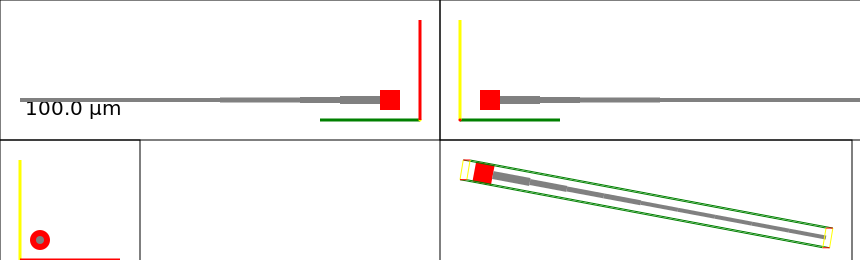

In [4]:
from pyneuroml import pynml
pynml.run_jneuroml("", nml_cell_file, '-svg', verbose=False)
from IPython.display import SVG, display
display(SVG(filename='%s'%nml_cell_file.replace('.nml','.svg')))

### Create a network using NeuroMLlite

See https://docs.neuroml.org/Userdocs/Software/NeuroMLlite.html

In [5]:
import neuromllite as nmllite


# Set up the network 
net = nmllite.Network(id='TestNet')
net.notes = 'Current clamp input'
net.parameters = { 'input_amp1':       '0.05nA', 'input_amp2':       '0.05nA'} 


# Add a NeuroMLlite cell, using the above file
nmllite_cell = nmllite.Cell(id=cell.id, neuroml2_source_file=nml_cell_file)
net.cells.append(nmllite_cell)


# Add current inputs to the network
input_source1 = nmllite.InputSource(id='i_clamp_early', 
                           neuroml2_input='PulseGenerator', 
                           parameters={'amplitude':'input_amp1', 'delay':'100ms', 'duration':'100ms'})

net.input_sources.append(input_source1)

input_source2 = nmllite.InputSource(id='i_clamp_late', 
                           neuroml2_input='PulseGenerator', 
                           parameters={'amplitude':'input_amp2', 'delay':'500ms', 'duration':'100ms'})

net.input_sources.append(input_source2)


# Create a region in 3D space (not really necessary for 1 cell, but useful if more added later)
r1 = nmllite.RectangularRegion(id='region1', x=0,y=0,z=0,width=1000,height=100,depth=1000)
net.regions.append(r1)


# Create a population of 1 cell
p0 = nmllite.Population(id='pop0', 
                        size=1, 
                        component=nmllite_cell.id, 
                        properties={'color':'1 0 0'},
                        random_layout = nmllite.RandomLayout(region=r1.id))

net.populations.append(p0)


# Add the inputs to the population
net.inputs.append(nmllite.Input(id='stim_soma',
                        input_source=input_source1.id,
                        population=p0.id,
                        percentage=100,
                        segment_ids=[0]))

net.inputs.append(nmllite.Input(id='stim_dend_tip',
                        input_source=input_source2.id,
                        population=p0.id,
                        percentage=100,
                        segment_ids=[9]))


# Print a summary of the network info
print(net)


# Save the NeuroMLlite network to a JSON file
new_file = net.to_json_file('%s.json'%net.id)


# Specify a NeuroMLlite simulation and save to file
sim = nmllite.Simulation(id='Sim%s'%net.id,
                 network=new_file,
                 duration='1000',
                 dt='0.025',
                 record_traces={'all':'*:%s'%([seg.id for seg in cell.morphology.segments])})
                 
sim.to_json_file()

Network(notes='Current clamp input', id='TestNet', parameters={'input_amp1': '0.05nA', 'input_amp2': '0.05nA'}, cells=[Cell(notes=None, id='BallAndStick', parameters=None, neuroml2_source_file='BallAndStick.cell.nml', lems_source_file=None, neuroml2_cell=None, pynn_cell=None, arbor_cell=None, bindsnet_node=None)], synapses=[], input_sources=[InputSource(notes=None, id='i_clamp_early', parameters={'amplitude': 'input_amp1', 'delay': '100ms', 'duration': '100ms'}, neuroml2_source_file=None, neuroml2_input='PulseGenerator', lems_source_file=None, pynn_input=None), InputSource(notes=None, id='i_clamp_late', parameters={'amplitude': 'input_amp2', 'delay': '500ms', 'duration': '100ms'}, neuroml2_source_file=None, neuroml2_input='PulseGenerator', lems_source_file=None, pynn_input=None)], regions=[RectangularRegion(notes=None, id='region1', x=0.0, y=0.0, z=0.0, width=1000.0, height=100.0, depth=1000.0)], populations=[Population(notes=None, id='pop0', size=1, component='BallAndStick', propertie

'SimTestNet.json'

### Generate the network and run it in NEURON

In [6]:
from neuromllite.NetworkGenerator import generate_and_run
traces, events = generate_and_run(sim, 
                                  simulator='jNeuroML_NEURON', 
                                  return_results =True)

libNeuroML >>> INFO - Loading NeuroML2 file: BallAndStick.cell.nml
libNeuroML >>> INFO - Loading NeuroML2 file: /Users/padraig/git/compbiolibs/ideas/pas.channel.nml
libNeuroML >>> WARNING - Id 'i_clamp_early' not found in TestNet
libNeuroML >>> WARNING - All ids: ['BallAndStick', 'TestNet', 'annotation', 'id', 'metaid', 'notes']
libNeuroML >>> WARNING - Id 'i_clamp_late' not found in TestNet
libNeuroML >>> WARNING - All ids: ['BallAndStick', 'TestNet', 'annotation', 'i_clamp_early', 'id', 'metaid', 'notes']
libNeuroML >>> WARNING - Id 'BallAndStick' not found in TestNet
libNeuroML >>> WARNING - All ids: ['TestNet', 'annotation', 'i_clamp_early', 'i_clamp_late', 'id', 'metaid', 'notes']
libNeuroML >>> INFO - Creating LEMS file at: ./LEMS_SimTestNet.xml for NeuroML 2 file: TestNet.net.nml (copy: True)
libNeuroML >>> INFO -  - Including BallAndStick.cell.nml (located at BallAndStick.cell.nml; nml dir: .), copying to .
libNeuroML >>> INFO - Loading NeuroML2 file: BallAndStick.cell.nml
libN

neuromllite >>> Loaded network specification from TestNet.json
neuromllite >>> Generating network TestNet and running in simulator: jNeuroML_NEURON...
neuromllite >>> Generating NeuroML2 for TestNet...
neuromllite >>> Starting net generation for TestNet...
neuromllite >>> *******************************************************
neuromllite >>> * NeuroMLDocument: TestNet
neuromllite >>> *
neuromllite >>> *  IncludeType: ['BallAndStick.cell.nml']
neuromllite >>> *  PulseGenerator: ['i_clamp_early', 'i_clamp_late']
neuromllite >>> *
neuromllite >>> *  Network: TestNet
neuromllite >>> *
neuromllite >>> *   1 cells in 1 populations 
neuromllite >>> *     Population: pop0 with 1 components of type BallAndStick
neuromllite >>> *       Locations: [(966.4535, 44.0733, 7.4915), ...]
neuromllite >>> *       Properties: color=1 0 0; region=region1; 
neuromllite >>> *
neuromllite >>> *   0 connections in 0 projections 
neuromllite >>> *
neuromllite >>> *   2 inputs in 2 input lists 
neuromllite >>> 

libNeuroML >>> INFO - Command completed successfully!


neuromllite >>> Finished running LEMS file LEMS_SimTestNet.xml in jNeuroML_NEURON (pyNeuroML v1.3.13 containing jNeuroML v0.13.3; returning results: True)
neuromllite >>> Returning 11 traces:
neuromllite >>>   pop0/0/BallAndStick/0/v (<class 'list'>): -0.065 -> -0.06999267 (min: -0.06999267, max: -0.03474697, len: 40001)
neuromllite >>>   pop0/0/BallAndStick/1/v (<class 'list'>): -0.065 -> -0.06999267 (min: -0.06999267, max: -0.03508661, len: 40001)
neuromllite >>>   pop0/0/BallAndStick/2/v (<class 'list'>): -0.065 -> -0.06999267 (min: -0.06999267, max: -0.03586008, len: 40001)
neuromllite >>>   pop0/0/BallAndStick/3/v (<class 'list'>): -0.065 -> -0.06999267 (min: -0.06999267, max: -0.03688495, len: 40001)
neuromllite >>>   ...
neuromllite >>> Returning 0 events:


### Plot the results

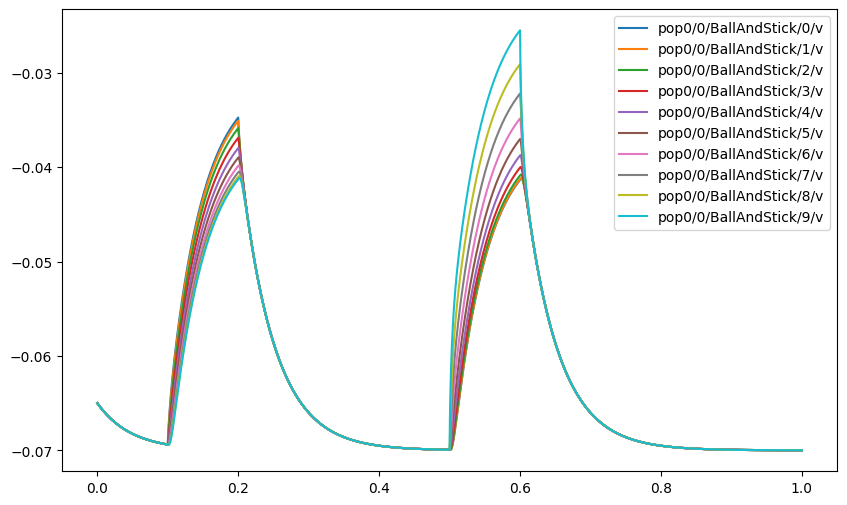

In [7]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(10,6), dpi= 100)
for trace in traces:
    if trace != 't':
        plt.plot(traces['t'],traces[trace],label=trace)
plt.legend()